# Построение baseline-решений
В этом задании вам предстоит построить несколько моделей и оценить их качество. Эти модели будут служить нам в качестве baseline-решений и пригодятся сразу для нескольких задач:\n", 
1. Во-первых, на разработку baseline-модели не должно уходить много времени (это требование исходит из оценок затрат на проект в целом - большую часть времени все же нужно потратить на основное решение), процесс должен быть простым, на подавляющем большинстве этапов должны использоваться готовые протестированные инструменты. Все это приводит к тому, что baseline-модели - это дешевый способ сделать грубую оценку потенциально возможного качества модели, при построении которого вероятность допущения ошибок относительно невелика.
2. Во-вторых, использование моделей разного типа при построении baseline'ов позволяет на раннем этапе сделать предположения о том, какие подходы являются наиболее перспективными и приоритизировать дальнейшие эксперименты.
3. Наличие baseline-моделей позволяет оценить, какой прирост качества дают различные преобразования, усложнения, оптимизации и прочие активности, которые вы предпринимаете для построения финального решения.
4. Наконец, если после построение сложного решения оценка его качества будет очень сильно отличаться от оценки качества baseline-моделей, то это будет хорошим поводом поискать в решении ошибки.

Обучите 3 разные baseline-модели на полученных наборах данных и оцените их качество. На прошлой неделе вы выбрали методику оценки качества моделей на основе кросс-валидации, а также основную и вспомогательные метрики. Оцените с их помощью получившуюся модель. Обратите внимание, что под разными моделями понимаются именно разные алгоритмы классификации. Например, 2 модели, реализующие метод k ближайших соседей с разными k, будут считаться одним baseline-решением (хотя и с разными параметрами). Напоминаем, что отложенная выборка (hold-out dataset) не должна использоваться для построения и оценки baseline-моделей!

Можно (но не обязательно) рассмотреть следующий набор алгоритмов:
1. Линейная модель (например, реализация sklearn.linear_model.RidgeClassifier)
2. Случайный лес (например, реализация sklearn.ensemble.RandomForestClassifier)
3. Градиентный бустинг (например, реализация sklearn.ensemble.GradientBoostingClassifier)

В качестве решения приложите получившийся jupyther notebook. Убедитесь, что в нем присутствуют:
- все baseline-модели, которые вы построили;
- качество всех построенных моделей оценено с помощью кросс-валидации, и это понятно из текста в jupyther notebook;
- все модели оценены с помощью основной и дополнительных метрик качества.

In [68]:
import pandas as pd
import random
import numpy as np
from scipy.sparse import coo_matrix, hstack
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, recall_score, precision_score, log_loss

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
seed = 8527
first_categorial_index = 190

Загрузим train dataset, выделенный на задании предыдущей недели

In [3]:
churn_data_frame = pd.read_csv("churn_data_train.csv")
churn_labels_frame = pd.read_csv("churn_labels_train.csv")
print(churn_data_frame.shape)
print(churn_labels_frame.shape)

(27999, 230)
(27999, 1)


## Общая предобработка признаков

In [43]:
def scale_frame(frame):
    # Функция масштабирует frame на отрезок [0;1]
    scaler = StandardScaler()
    scaled_matrix = scaler.fit_transform(frame.as_matrix())
    return pd.DataFrame(scaled_matrix, columns=frame.columns)

def split_frame(frame, n_columns, c_columns):
    # Функция разбивает фрейм на два числовой и категориальный, а также масштабирует значения и заполняет пропуски.
    n_frame = frame[n_columns].copy()
    c_frame = frame[c_columns].copy()
    # Посчитаем средние по колонкам
    numeric_means = n_frame.mean(axis=0, skipna=True)
    # Оставим только те колонки, в которых среднее значение не равно NaN, т.к. в таких колонках совсем нет значений
    numeric_means = numeric_means.dropna()
    dropped_numeric_colums = n_frame.columns.drop(numeric_means.index)
    n_frame = n_frame[list(numeric_means.index)]
    # Заполним пропущенные численные значения средними
    n_frame = n_frame.fillna(numeric_means, axis=0)
    # Заполним пропущенные категориальные значения строками "NaV" (Not a value)
    c_frame = c_frame.fillna("NaV")
    # Посчитаем количества уникальных значений по колонкам
    cat_unique_counts = c_frame.nunique()
    num_unique_counts = n_frame.nunique()
    # Удалим колонки с одним уникальным значением
    cat_columns_to_drop = cat_unique_counts[cat_unique_counts == 1].index
    num_columns_to_drop = num_unique_counts[num_unique_counts == 1].index
    c_frame = c_frame.drop(cat_columns_to_drop, axis=1)
    n_frame = n_frame.drop(num_columns_to_drop, axis=1)
    
    dropped_columns = np.concatenate([
        dropped_numeric_colums,
        list(num_columns_to_drop),
        list(cat_columns_to_drop)])
    return (n_frame, c_frame, dropped_columns)

Разделим коллекции на группы - числовые и категориальные.
Выполним начальные преобразования, которые мы делали на 1-й неделе
- заполним пропущенные числовые значения средними по колонке
- заполним пропущенные категориальные значения строками "NaV" (Not a Value)
- удалим колонки без значений и с одним уникальным значением, т.к. они не сыграют в модели

Все эти действия производятся в функции split_frame (см. выше)

In [44]:
numeric_columns = churn_data_frame.columns[:first_categorial_index]
categorial_columns = churn_data_frame.columns[first_categorial_index:]

numeric_frame, categorial_frame, dropped_columns = split_frame(churn_data_frame, numeric_columns, categorial_columns)

Масштабируем числовые признаки

In [48]:
numeric_frame_scaled = scale_frame(numeric_frame)

Закодируем категориальные признаки значениями от 0 до n

In [49]:
def label_encode(X_categorial):
    # Функция кодирует категории числами от 0 до n, где n количество категорий в колонке
    X_num = np.empty(X_categorial.shape)
    for column_number in range(X_categorial.shape[1]):
        labelEncoder = LabelEncoder()
        column = X_categorial[:,column_number]
        for idx, val in enumerate(column): 
            if(not(isinstance(val, str))):
                column[idx] = "NaV"
        num_column = labelEncoder.fit_transform(column)
        for row_number, val in enumerate(num_column):
            X_num[row_number, column_number] = val
    return X_num

In [50]:
categorial_frame_labeled = pd.DataFrame(
    label_encode(categorial_frame.as_matrix()),
    columns=categorial_frame.columns)

## Организация оценки качества

Функция ниже разбивает выборку на несколько стратифицированных фолдов. После этого по каждому из фолдов строит модель, используя model_factory и обучает её. На полученной обученной модели функция строит предсказания и по ним считает F-меру.
Функция возвращает усредненное по всем фолдам значение F-меры.

In [52]:
def stratifiedKFold_fscore(X, y, model_factory, seed, folds_count = 3):
    # Функция разбивает набор данных на folds_count, считает F-меру на каждом фолде и возвращает усредненное по фолдам значение.
    skf = StratifiedKFold(n_splits=folds_count, shuffle=True, random_state=seed)
    f_score_sum = 0
    # Функция также возвращает модель, показавшую лучшее качество, её метрики и разделение данных
    # Разделение данных нужно для того, чтобы строить метрики модели на данных, на которых она не обучалась.
    best_model = None
    best_score = 0
    best_precision = 0
    best_recall = 0
    best_table = None
    best_split = None
    for train_indices, test_indices in skf.split(X, y):
        X_train = X.tocsc()[train_indices]
        X_test = X.tocsc()[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        model = model_factory()
        # Обучим модель
        model.fit(X_train, y_train)
        # Построим предсказания для расчета оценки
        y_predicted = model.predict(X_test)
        fscore = f1_score(y_test, y_predicted)
        if(best_model is None or best_score < fscore):
            # В случае, если модель лучше предыдущих сохраним её оценку, модель, матрицу ошибок и разделение данных
            best_score = fscore
            best_model = model
            best_split = (X_train, y_train, X_test, y_test)
        f_score_sum += fscore
    return (
        float(f_score_sum)/float(folds_count),
        best_model,
        best_score,
        best_split)

## Построение baseline моделей
Для обработки категориальных признаков при построении baseline модели будем использовать OneHotEncoder и LabelEncoder.
Эти методы крайне просты. Другие методы обработки категориальных признаков несколько более сложны и не укладываются в рамки построения baseline модели.

Закодируем категориальные признаки с помощью OneHotEncoder и объединим матрицы вещественных и бинарных признаков.

In [54]:
one_hot = OneHotEncoder()
cat_mtx = one_hot.fit_transform(categorial_frame_labeled.as_matrix())
X_one_hot = hstack([coo_matrix(numeric_frame_scaled.as_matrix()), cat_mtx])
y = churn_labels_frame.as_matrix().flatten()

Линейная модель

In [55]:
ridge_one_hot = stratifiedKFold_fscore(X_one_hot, y, RidgeClassifier, seed)
ridge_one_hot[0]

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

Случайный лес

In [57]:
random_forest_one_hot = stratifiedKFold_fscore(X_one_hot, y, RandomForestClassifier, seed)
random_forest_one_hot[0]

0.00381361128142244

Лог.регрессия

In [69]:
log_reg_one_hot = stratifiedKFold_fscore(X_one_hot, y, LogisticRegression, seed)
log_reg_one_hot[0]

0.05840238024182245

Объединим матрицы вещественных и категориальных признаков, закодированных целыми числами

In [60]:
X_labeled = coo_matrix(pd.concat([numeric_frame_scaled, categorial_frame_labeled], axis=1, ignore_index=False).as_matrix())

Случайный лес

In [61]:
random_forest_labeled = stratifiedKFold_fscore(X_labeled, y, RandomForestClassifier, seed)
random_forest_labeled[0]

0.006642281346181789

Лог.регрессия

In [72]:
log_reg_labeled = stratifiedKFold_fscore(X_labeled, y, LogisticRegression, seed)
log_reg_labeled[0]

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.004730899012053233

Линейная модель

In [71]:
ridge_labeled = stratifiedKFold_fscore(X_labeled, y, RidgeClassifier, seed)
ridge_labeled[0]

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

Сравним получившиеся оценки объединив их в таблицу

In [73]:
score_table = pd.DataFrame(
    [
        [ridge_one_hot[0], ridge_labeled[0], ridge_one_hot[2], ridge_labeled[2]],
        [random_forest_one_hot[0], random_forest_labeled[0], random_forest_one_hot[2], random_forest_labeled[2]],
        [log_reg_one_hot[0], log_reg_labeled[0], log_reg_one_hot[2], log_reg_labeled[2]]
    ],
    index=["Ridge", "Random forest", "logistic regression"],
    columns=["One hot mean", "Labeled mean", "One hot best", "Labeled best"])
score_table

,One hot mean,Labeled mean,One hot best,Labeled best
Ridge,0.000000,0.000000,0.000000,0.000000
Random forest,0.003814,0.006642,0.008584,0.011380
logistic regression,0.058402,0.004731,0.082927,0.008487


Результаты построениея моделей достаточно предсказуемы. Качество предсказания никакое. OneHot обработка признаков улучшает качество предсказаний для линейной модели и отрицательно сказывается на качестве моделей, основанных на решающих деревьях.

## Дополнительные метрики качества

Для каждого типа baseline модели возьмем лучшее решение и сравним эти решения на основе основной (F-мера) и дополнительных (precision, recall, log loss, roc auc score) метрик качества.

In [74]:
def predict_ridge_proba(X, model):
    # Функция возвращает вероятности предсказаний для класса churn модель Ridge
    # Поскольку RidgeClassifier не обладает функцией predict_proba приходится считать его вручную
    func = model.decision_function(X)
    return np.exp(func) / (1 + np.exp(func))

def predict_model_proba(X, model):
    # Функция возвращает вероятности предсказаний для класса churn
    return list(zip(*model.predict_proba(X)))[1]

def get_model_data(model_with_data):
    # Функция принимает на вход результат stratifiedKFold_fscore и возвращает только модель и её X_test и y_test
    model = model_with_data[1]
    split = model_with_data[3]
    X = split[2]
    y = split[3]
    return (model,X,y)

def calculate_metrics(model_with_data, predict_probabilities):
    # Посчитаем метрики качества для модели
    model, X, y = get_model_data(model_with_data)
    predictions = model.predict(X)
    probabilities = predict_probabilities(X, model)
    # Считаем F-меру, precision и recall
    fscore = f1_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    # Считаем Log loss
    logLoss = log_loss(y, probabilities)
    # Считаем roc auc score
    rocAuc = roc_auc_score(y, probabilities)
    return (precision,recall,fscore,logLoss,rocAuc)

Посчитаем метрики качества и сведем их в одну таблицу

In [84]:
score_table = pd.DataFrame(
    [
        calculate_metrics(ridge_one_hot, predict_ridge_proba),
        calculate_metrics(random_forest_labeled, predict_model_proba),
        calculate_metrics(log_reg_one_hot, predict_model_proba)
    ],
    index=["Ridge", "Random forest", "Logistic Regression"], 
    columns=["Precision", "Recall", "F-Score", "Log Loss", "Roc Auc"])
score_table

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Precision,Recall,F-Score,Log Loss,Roc Auc
Ridge,0.000000,0.000000,0.000000,0.414510,0.681390
Random forest,0.444444,0.005764,0.011380,1.089430,0.576341
Logistic Regression,0.269841,0.048991,0.082927,0.293363,0.633306


Из таблицы видно, что Ridge Classifier не безнадежен, если получится увеличить recall, то он, возможно, сможет показать результат, сравнимый с другими моделями.
Также видно, что в основном плохие оценки получаются из-за низкого значения метрики recall. Значение метрики precision также оставляет желать лучшего, но все-таки значительно лучше, чем recall.

## Графики

In [79]:
def transform_to_chart_model(label, model_with_data, predict_probabilities):
    # Функция принимает на вход заголовок, результат функции stratifiedKFold_fscore и функцию, считающую вероятности и возвращает заголовок, вектор ответов и вектор вероятностей для построения графиков
    model, X, y = get_model_data(model_with_data)
    probabilities = predict_probabilities(X, model)
    return (label, y, probabilities)

def charts_row(model_charts, chart_builder, figsize=(11, 4)):
    # Функция принимает данные для построения графиков и логику построения одного графика и строит графики в одну строку
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(model_charts),
        figsize=figsize,
        sharey=True) 
    for i, chart_data in enumerate(model_charts):
        ax = axes[i]
        chart_builder(chart_data, ax, i)
    plt.show()

def scatter(chart_data, ax, ax_index, T=0.5):
    # Функция строит график распределения вероятностей по классам
    label, actual, predicted = chart_data
    ax.scatter(actual, predicted)
    ax.set_xlabel("Labels") 
    if ax_index == 0:
        ax.set_ylabel("Predicted probabilities")
    ax.set_title(label)
    ax.plot([-1.1, 1.2], [T, T])
    ax.axis([-1.1, 1.1, -0.1, 1.1])

def precision_recal_thresh(chart_data, ax, ax_index):
    # Функция строит графики значений precision и recall в зависимости от порога
    label, actual, predicted = chart_data
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    min_len = min([len(prec),len(rec),len(thresh)])
    ax.plot(thresh[:min_len], prec[:min_len], label="precision")
    ax.plot(thresh[:min_len], rec[:min_len], label="recall") 
    ax.legend(loc=1)
    ax.set_xlabel("threshold")
    ax.set_title(label)

def auc_prc(chart_data, ax, ax_index):
    # Функция строит график AUC PRC (зависимость precision от recall)
    label, actual, predicted = chart_data
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    min_len = min([len(prec),len(rec),len(thresh)])
    ax.plot(rec[:min_len], prec[:min_len])
    ax.set_xlabel("recall")
    if ax_index == 0:
        ax.set_ylabel("precision")
    ax.set_title(label)

def calc_min_distance (actual,predicted):
    # Функция считает минимальное расстояние до точки [0;1] для AUC ROC
    fpr,tpr,thr = roc_curve(actual,predicted)
    distance,fpr_v,tpr_v,thr_v = min(zip(np.sqrt((1.-tpr)**2+fpr**2),fpr,tpr,thr), key=lambda d:d[0])
    return (distance,fpr_v,tpr_v,thr_v)

def auc_roc(chart_data, ax, ax_index):
    # Функция строит кривую AUC ROC и отмечает точку, соответствующую минимальному расстоянию до точки [0;1]
    label, actual, predicted = chart_data
    fpr, tpr, thr = roc_curve(actual, predicted)
    min_dist,min_fpr,min_tpr,_ = calc_min_distance(actual, predicted)
    ax.plot(fpr, tpr, label="ROC AUC curve")
    ax.scatter(min_fpr,min_tpr,color="red")
    ax.set_xlabel("false positive rate")
    if ax_index == 0:
        ax.set_ylabel("true positive rate")
    ax.legend(loc=4)
    ax.set_title(label)

Подготовим модель для построения графиков

In [85]:
chart_models = [transform_to_chart_model(t, m, pp) for t, m, pp in zip(
    ["Ridge One Hot", "Random forest labeled", "Logistic Regression One Hot"],
    [ridge_one_hot, random_forest_labeled, log_reg_one_hot],
    [predict_ridge_proba, lambda x, m: list(zip(*m.predict_proba(x)))[1], lambda x, m: list(zip(*m.predict_proba(x)))[1]]
)]

### Графики распределения вероятностей класса churn по реальным значениям меток классов

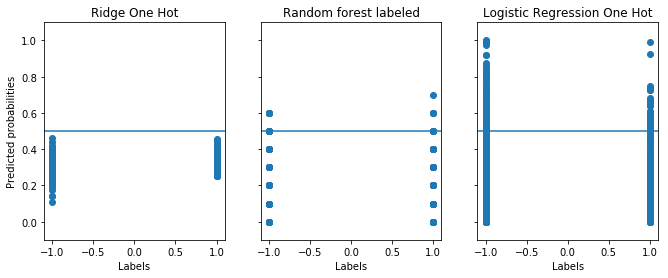

In [86]:
charts_row(chart_models, scatter)

Из графиков видно, что вероятности классов находятся достаточно плотно друг к другу и для данных моделей настройка порога не сыграет большой роли в качестве решения.

### Графики зависимости precision и recall от значений порога

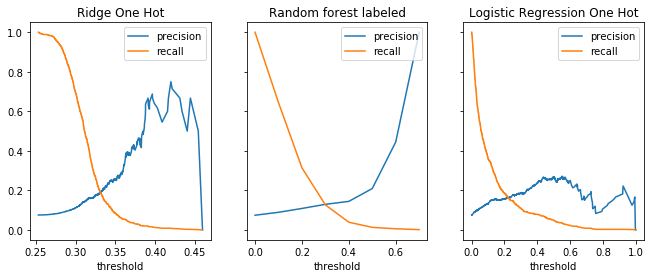

In [87]:
charts_row(chart_models, precision_recal_thresh)

По данным графикам видно, что можно подобрать порог так, чтобы за счет precision увеличить recall. Существенно выиграть в качестве при этом пока не получится.

### Кривые AUC ROC

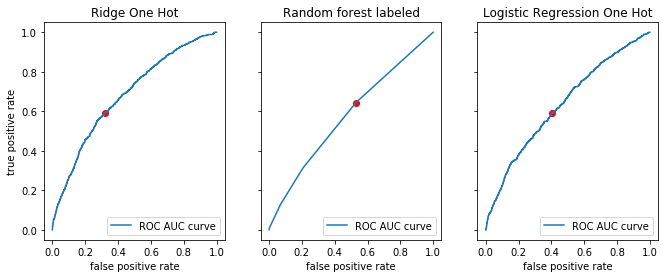

In [88]:
charts_row(chart_models, auc_roc)

По кривым AUC ROC видно, что они проходят довольно далеко от точки [0;1], это означает, что качество моделей низкое. И простой подстройкой параметров не обойтись.

### Кривые AUC PRC

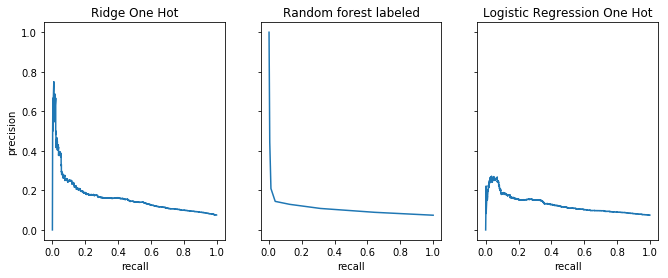

In [89]:
charts_row(chart_models, auc_prc)

По графикам также видно, что общее качество моделей очень низкое (они проходят далеко от точки [1;1]

## Вывод

В этой работе я написал функции, обрабатывающие признаки для построения модели (масштабирование числовых признаков, кодирование категориальных признаков)
Подготовил функции, позволяющие произвести оценку качества моделей по F-мере на кросс-валидации.
Подготовил функции, позволяющие произвести дополнительную оценку качества модели и качество оценок принадлежности классу.
Построил baseline модели и измерил их качество.

Качество baseline моделей оказалось предсказуемо низким.
